In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

### 1. Creating a toy multi-class dataset

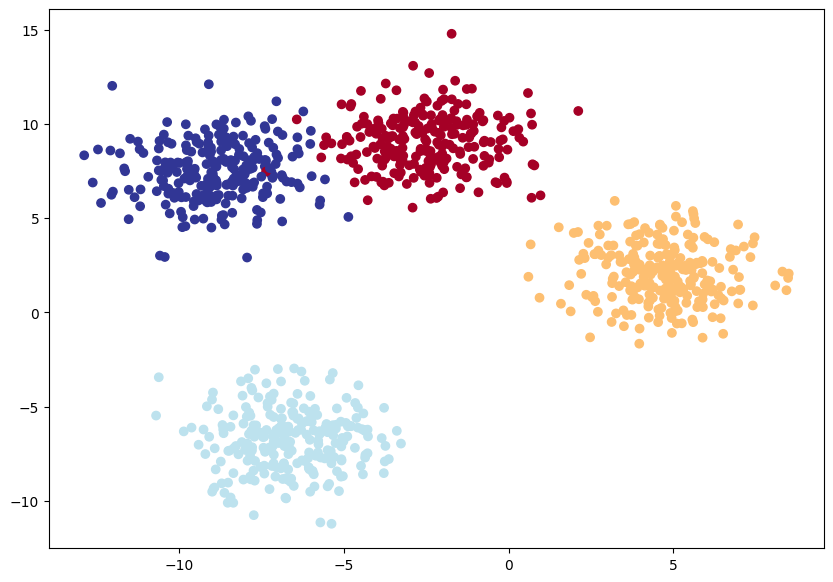

In [2]:
# Import dependencies
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 2. Building a multi-class classification model in PyTorch

In [3]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_1 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [5]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [6]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 3. Create a loss function and an optimizer for a multi-class classification model

In [7]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


### 4. Getting prediction probabilities for a multi-class PyTorch model

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [8]:
# Raw outputs of our model (logits)
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_blob_test.to(device))

y_logits[:10]

tensor([[ 0.0381, -0.3849,  0.1379, -0.0360],
        [ 0.4434,  0.0411,  0.8245,  0.0427],
        [-0.2287, -0.5744, -0.5629,  0.2705],
        [ 0.0940, -0.4376,  0.0774,  0.0112],
        [ 0.0650, -0.2769,  0.1545, -0.2888],
        [ 0.5218,  0.0713,  0.9483,  0.0422],
        [-0.2597, -0.5005, -0.4552,  0.1933],
        [ 0.0691, -0.1783,  0.3063, -0.2859],
        [-0.1538, -0.6038, -0.4912,  0.2476],
        [ 0.0424, -0.2315,  0.2135, -0.2858]])

In [9]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [10]:
# Convert model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.0381, -0.3849,  0.1379, -0.0360],
        [ 0.4434,  0.0411,  0.8245,  0.0427],
        [-0.2287, -0.5744, -0.5629,  0.2705],
        [ 0.0940, -0.4376,  0.0774,  0.0112],
        [ 0.0650, -0.2769,  0.1545, -0.2888]])
tensor([[0.2711, 0.1776, 0.2996, 0.2518],
        [0.2630, 0.1759, 0.3850, 0.1762],
        [0.2456, 0.1738, 0.1758, 0.4047],
        [0.2864, 0.1683, 0.2817, 0.2636],
        [0.2852, 0.2026, 0.3119, 0.2002]])


In [11]:
# Convert model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([2, 2, 3, 0, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3,
        3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2,
        2, 2, 0, 2, 2, 0, 2, 3, 2, 0, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 2, 2, 2, 2, 0, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 0, 2, 2, 2,
        0, 2, 2, 3, 2, 2, 2, 2, 3, 2, 0, 2, 2, 3, 0, 0, 2, 3, 3, 2, 2, 2, 0, 3,
        3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 0, 0, 2, 3, 3,
        3, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2,
        3, 3, 3, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2,
        0, 2, 3, 2, 2, 0, 3, 2])

In [12]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 5. Creating a training loop and testing loop for a multi-class PyTorch model

In [13]:
y_blob_train.dtype

torch.int64

In [14]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [15]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_1.train()

  y_logits = model_1(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 1.6231, Acc: 0.25% | Test loss: 1.3697, Test acc: 33.00%
Epoch: 10 | Loss: 0.5423, Acc: 97.75% | Test loss: 0.5083, Test acc: 97.50%
Epoch: 20 | Loss: 0.3414, Acc: 98.88% | Test loss: 0.3426, Test acc: 99.50%
Epoch: 30 | Loss: 0.2762, Acc: 99.00% | Test loss: 0.2793, Test acc: 99.50%
Epoch: 40 | Loss: 0.2372, Acc: 99.00% | Test loss: 0.2396, Test acc: 99.50%
Epoch: 50 | Loss: 0.2089, Acc: 99.12% | Test loss: 0.2103, Test acc: 99.50%
Epoch: 60 | Loss: 0.1868, Acc: 99.12% | Test loss: 0.1871, Test acc: 99.50%
Epoch: 70 | Loss: 0.1688, Acc: 99.12% | Test loss: 0.1683, Test acc: 99.50%
Epoch: 80 | Loss: 0.1539, Acc: 99.12% | Test loss: 0.1525, Test acc: 99.50%
Epoch: 90 | Loss: 0.1413, Acc: 99.12% | Test loss: 0.1392, Test acc: 99.50%


### 6. Making and evaluating predictions with a PyTorch multi-class model

In [16]:
# Make predictions
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 0.8800,  7.3324, -3.3820, -7.0481],
        [ 1.7754, -4.3821, -1.8536,  6.7886],
        [-0.4962, -0.4919,  1.2972, -0.5383],
        [-0.4499,  4.5595, -1.4363, -4.0688],
        [ 5.9469,  0.4929, -4.8580, -4.9579],
        [ 1.9874, -5.0957, -2.3249,  8.1682],
        [-0.4962, -0.4919,  1.2972, -0.5383],
        [ 5.2112, -1.5525, -3.6106, -1.7112],
        [-0.4962, -0.4919,  1.2972, -0.5383],
        [ 5.3736, -0.7989, -3.9727, -2.9282]])

In [17]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.5742e-03, 9.9840e-01, 2.2187e-05, 5.6749e-07],
        [6.6046e-03, 1.3985e-05, 1.7530e-04, 9.9321e-01],
        [1.1144e-01, 1.1193e-01, 6.6978e-01, 1.0686e-01],
        [6.6135e-03, 9.9074e-01, 2.4661e-03, 1.7732e-04],
        [9.9570e-01, 4.2608e-03, 2.0214e-05, 1.8292e-05],
        [2.0645e-03, 1.7324e-06, 2.7669e-05, 9.9791e-01],
        [1.1144e-01, 1.1193e-01, 6.6978e-01, 1.0686e-01],
        [9.9772e-01, 1.1523e-03, 1.4714e-04, 9.8315e-04],
        [1.1144e-01, 1.1193e-01, 6.6978e-01, 1.0686e-01],
        [9.9758e-01, 2.0808e-03, 8.7078e-05, 2.4748e-04]])

In [18]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [19]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print('Downloading helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/Claudiu-Mihael-Terenche/Machine-Learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

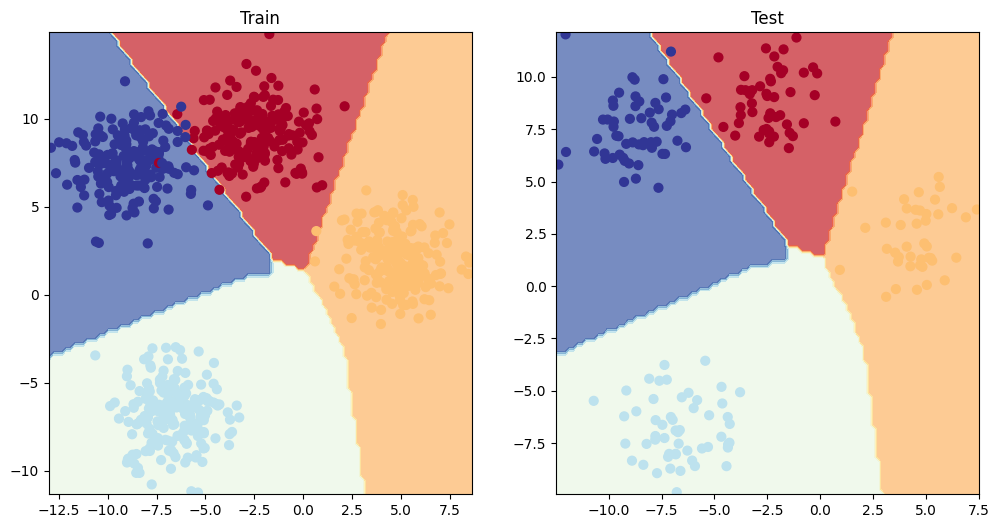

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_blob_test, y_blob_test)

In [21]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [22]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950)

In [23]:
torchmetric_accuracy.device

device(type='cpu')